In [77]:
import pandas as pd
import numpy as np
from distance_benchmark import compute_pfipf

In [18]:
org_cell = np.load("../data/testing_data/output_org_osaka20/cell_traj.npy")
ref_cell = np.load("../data/testing_data/output_ref_osaka20/cell_traj.npy")

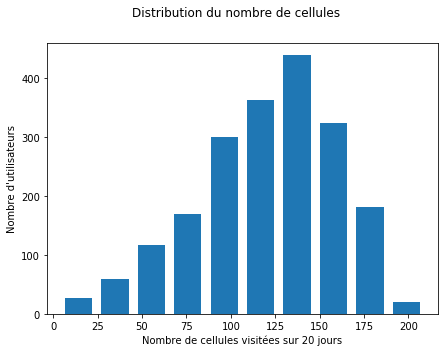

In [307]:
import matplotlib.pyplot as plt

@njit
def histogram_nb_visit(arr):
    assert arr.ndim == 2
    res = np.zeros(arr.shape[0])
    for i in range(arr.shape[0]):
        res[i] = np.unique(arr[i]).shape[0]
    return res

fig, ax1 = plt.subplots(1, figsize=(7, 5))
fig.suptitle('Distribution du nombre de cellules')
ax1.hist(histogram_nb_visit(org_cell[:, :]), rwidth=0.75)
ax1.set_xlabel("Nombre de cellules visitées sur 20 jours")
ax1.set_ylabel("Nombre d'utilisateurs")
plt.show()

In [189]:
fun_exp = [1, 1, 2, 3]
fun_exp_pfipf = [1, 1, 2, 3]

In [315]:
def mv_cell(cell_number, x, y):
    x_pos = cell_number % 32
    x_pos = 32 if x_pos == 0 else x_pos
    y_pos = int((cell_number - 1) / 32)
    
    #assert 1 <= x_pos + x < 33, "depassing x limits"
    #assert 0 <= y_pos + y < 32, "depassing y limits"
    if not ((1 <= x_pos + x < 33)) or not((0 <= y_pos + y < 32)):
        return cell_number
    
    x_pos += x
    y_pos += y
    
    return x_pos + 32*(y_pos)

def freq_pos_pers(array_pos):
    pos, frq = np.unique(array_pos, return_counts=True)
    frq = frq/400
    
    return pos, frq

from tqdm import tqdm

def anonymize(array):
    
    array = array.copy()
    
    for i in tqdm(range(array.shape[0])):
        pos, freq = freq_pos_pers(array[i])
        x = 0
        y = 0
        while (x == 0) and (y == 0):
            x = np.random.randint(-1,2)
            y = np.random.randint(-1,2)
        #stats = pd.DataFrame(freq).describe().T
        
        factor = freq.copy()
        first_perc = (int(freq.shape[0]*0.01)) or 1
        second_perc = (int(freq.shape[0]*0.04)) + first_perc
        third_perc = (int(freq.shape[0]*0.25)) + second_perc
        factor[np.argsort(freq)[-first_perc:]] = fun_exp[-1]
        factor[np.argsort(freq)[-second_perc:-first_perc]] = fun_exp[-2]
        factor[np.argsort(freq)[-third_perc:-second_perc]] = fun_exp[-3]
        factor[np.argsort(freq)[:-third_perc]] = fun_exp[-4]
        #factor[np.nonzero(factor <= stats["25%"].values[0])] = fun_exp[0]
        #factor[np.nonzero(np.logical_and(factor > stats["25%"].values[0], factor <= stats["50%"].values[0]))] = fun_exp[1]
        #factor[np.nonzero(np.logical_and(factor > stats["50%"].values[0], factor <= stats["75%"].values[0]))] = fun_exp[2]
        #factor[np.nonzero(np.logical_and(factor > stats["75%"].values[0], factor < 1))] = fun_exp[3]j
        
        for j in range(array[i].shape[0]):
            cell = array[i][j].copy()
            factor_j = factor[np.where(pos == cell)[0]]
            array[i][j] = mv_cell(cell, x*factor_j, y*factor_j)
            
    return array

def anonymize_pfipf(array, first=0.03, second=0.02, third=0.25, random=False):
    array = array.copy()
    pfipf = compute_pfipf(array, number_people=2000, upper_bound=1024)
    
    for i in tqdm(range(array.shape[0])):
        x = 0
        y = 0
        while (x == 0) and (y == 0):
            x = np.random.randint(-1,2)
            y = np.random.randint(-1,2)
            
        first_perc = (int(np.count_nonzero(pfipf[i])*first)) or 5
        second_perc = (int(np.count_nonzero(pfipf[i])*second)) + first_perc
        third_perc = (int(np.count_nonzero(pfipf[i])*third)) + second_perc

        factor = pfipf[i].copy()
        factor[np.argsort(pfipf[i])[-first_perc:]] = fun_exp_pfipf[-1]
        factor[np.argsort(pfipf[i])[-second_perc:-first_perc]] = fun_exp_pfipf[-2]
        factor[np.argsort(pfipf[i])[-third_perc:-second_perc]] = fun_exp_pfipf[-3]
        factor[np.argsort(pfipf[i])[:-third_perc]] = fun_exp_pfipf[-4]
        
        # first pfipf send at random
        if random:
            factor[np.argsort(pfipf[i])[-1]] = -1
        
        for j in range(array[i].shape[0]):
                cell = array[i][j].copy()
                factor_j = factor[cell]
                if factor_j == -1:
                    array[i][j] = np.random.randint(1,1025)
                else:
                    array[i][j] = mv_cell(cell, x*factor_j, y*factor_j)

    return array

In [312]:
ano_org_cell = anonymize_pfipf(org_cell)

#ano_org_cell = anonymize(org_cell)

100%|██████████| 2000/2000 [00:09<00:00, 219.13it/s]


In [313]:
df_ano = pd.DataFrame(ano_org_cell)
df_ano = df_ano.reset_index()
df_ano["index"] = df_ano.index + 1
df_ano = df_ano.melt("index").sort_values(["index", "variable"]).reset_index(drop=True).drop("variable", axis=1)
df_ano = df_ano.rename(columns={"index": "user_id", "value": "reg_id"})

In [314]:
df_ano.reg_id.to_csv("anonymized.csv", index=False, header="reg_id")

In [290]:
import math
from numba import njit

def create_mapping(size):
    map_cell = {}
    assert 32 % size == 0, "cannot shrink map to size"
    for i in range(32//size):
        for j in range(32//size):
            cell_left_above = (j*size)+1 + (i*math.pow(size,2)*(32//size))
            ind_cell_map = 32//size*i+j
            map_cell[ind_cell_map] = []
            #do something with i
            for k in range(size):
                for l in range(size):
                    map_cell[ind_cell_map].append(mv_cell(cell_left_above, k, l))
                    
    mapping = pd.DataFrame(map_cell).T.reset_index().melt("index").drop("variable", axis=1).sort_values("value").reset_index(drop=True)
    mapping.columns = ["reg_id_ext", "reg_id"]
    
    return np.array(mapping.reg_id_ext).astype(int)+1

@njit
def mapp_cell_to_extended(array, reg_id_ext):
    array = array.copy()
    for i in range(array.shape[0]):
        for j in range(array.shape[1]):
            array[i][j] = reg_id_ext[array[i][j]-1]
            
    return array

In [294]:
reg_id_ext = create_mapping(2)

In [295]:
mapp_cell_to_extended(org_cell, reg_id_ext)

array([[159, 111,  78, ..., 164, 134, 115],
       [169, 169, 153, ..., 168, 168, 246],
       [ 89,  89,  89, ...,  88,  71,  71],
       ...,
       [ 72,  40,  56, ..., 102, 102,  88],
       [ 72, 121,  73, ..., 152, 152, 137],
       [185, 185, 153, ..., 137,  88, 105]])